# Human vs AI Text Classification

This notebook demonstrates a machine learning approach to distinguish between human-written and AI-generated texts using TF-IDF features and classic classifiers. The goal is to evaluate different models, visualize insights, and save the best-performing one for deployment.


In [34]:
# Import required libraries

# Core
import pandas as pd
import numpy as np
import joblib
import warnings
import string
import os
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP and ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Step 1: Load the Dataset

We load the custom dataset containing 5,000 samples (2,500 human-written, 2,500 AI-generated) using `pandas.read_csv`. The dataset is preprocessed and 
saved as a CSV file inside the `data/` directory.

In [35]:
# Load dataset
df = pd.read_csv("../data/your_dataset_5000.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5000, 2)


,text,label
0,Exercise plays a crucial role in supporting me...,1
1,Renewable energy helps fight climate change by...,1
2,"A futuristic smart city is a vibrant, intercon...",1
3,Healthy eating habits are especially important...,1
4,Machine learning is transforming healthcare by...,1


### Step 2: Text Preprocessing
We clean the text by lowercasing and removing punctuation. 
This ensures consistency before TF-IDF feature extraction.

In [36]:
# Text preprocessing

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,!?']", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
df["text"] = df["text"].apply(clean_text)
df[["text", "label"]].head()

,text,label
0,exercise plays a crucial role in supporting me...,1
1,renewable energy helps fight climate change by...,1
2,"a futuristic smart city is a vibrant, intercon...",1
3,healthy eating habits are especially important...,1
4,machine learning is transforming healthcare by...,1


### Explanation: Text Preprocessing 

#### What the Code Does
This step standardizes the raw text data to prepare it for feature extraction using TF-IDF. The clean_text() function performs the following operations:

- **Lowercasing**: Converts all characters to lowercase for consistency.
- **Punctuation removal**: Uses regular expressions to remove non-alphanumeric characters.
- **Whitespace normalization**: Replaces multiple spaces with a single space and removes leading/trailing whitespace.

### Step 3: Train-Test Split
Split the dataset into training and test sets (80/20 split).
This allows us to evaluate model performance on unseen data.

In [37]:
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 4000
Test size: 1000


### Explanation: Train-Test-Split
The dataset was split into training and test sets using an 80/20 ratio:

- **Total samples**: 5,000  
  - 2,500 human-written  
  - 2,500 AI-generated
- **Training set**: 4,000 samples  
- **Test set**: 1,000 samples

#### Why This Step Matters

- Ensures **fair evaluation** by testing on unseen data.
- Helps detect **overfitting** if the model performs well on training data but poorly on test data.
- Using `random_state=42` guarantees **reproducibility** — the same data split is created each time the notebook is run.


### Step 4: TF-IDF Vectorization
Convert cleaned text into numerical vectors using TF-IDF.
This represents the importance of words across the dataset.

In [38]:
# Define and train Random Forest
model_rf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(random_state=42))
])
model_rf.fit(X_train, y_train)

# Define and train Linear SVC
model_svm = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC())
])
model_svm.fit(X_train, y_train)

# Define and train Naive Bayes
model_nb = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [39]:
# Evaluate
print(f"\nTrain Accuracy: {model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.2f}")


Train Accuracy: 1.00
Test Accuracy: 1.00


### Explanation: TF-IDF Vectorization
This step converts raw text into numerical form using TfidfVectorizer, which is then passed to a classifier (e.g., LogisticRegression) to learn the patterns and classify the text.

- **Pipeline**:  
  TfidfVectorizer ➝ LogisticRegression
- **Purpose**:  
  The model is trained on this transformed data to distinguish between **human-written** and **AI-generated** text.

#### Visual Output

- The notebook displays a **visual pipeline diagram** showing:

- - This confirms that the pipeline was successfully constructed and fitted.

#### Why It Matters

- Provides a **clear, interactive representation** of your model's workflow.
- Enhances **readability** and ensures all pipeline components are **correctly connected**.

### Model Accuracy with TF-IDF + Logistic Regression

The model achieved **100% accuracy** on both the training and test datasets when using TfidfVectorizer with LogisticRegression.

#### What This Means:
- The model perfectly **learned to distinguish** between human-written and AI-generated text based on the provided features.
- This suggests a **very high class separability**, likely due to a **well-defined and synthetic dataset**.

#### Considerations:
- While 100% accuracy looks impressive, it may also indicate that:
  - The dataset is **too clean or artificial**.
  - The model hasn't been tested on **real-world noisy or ambiguous text**.
  
#### Educational Context:
- In this **demo/academic project**, such perfect accuracy is acceptable because:
  - The dataset is **balanced and well-labeled**.
  - The focus is on demonstrating a clear pipeline and model evaluation process.
  
In real-world settings, however, we would:
- Introduce **messier samples** (e.g., tweets, blog posts).
- Evaluate the model’s **generalization capability** beyond this controlled dataset.


In [40]:
# Predict on new samples
new_texts = [
    "Space exploration is crucial for the future of humanity.",
    "Eating fruits and vegetables is essential for good health."
]

predictions = model.predict(new_texts)
for text, label in zip(new_texts, predictions):
    print("\nText:", text)
    print("Predicted Label:", label)


Text: Space exploration is crucial for the future of humanity.
Predicted Label: 0

Text: Eating fruits and vegetables is essential for good health.
Predicted Label: 1


### Explanation: New Custom Input Predictions

The model was evaluated on **two new custom input sentences** to verify its ability to generalize to unseen data.

#### Label Definitions:
- Label 0 → **Human-written**
- Label 1 → **AI-generated**

#### Model Predictions:
- "Space exploration..." → **Predicted as Human-written** (`0`)
- "Eating fruits..." → **Predicted as AI-generated** (`1`)

#### Interpretation:
- The model likely associated the **abstract, idea-driven phrasing** of the first sentence with human authorship.
- The second sentence’s **structured, factual style** was likely interpreted as AI-generated — aligning with how the model learned language patterns during training.

This result demonstrates the model's ability to make predictions **based on learned stylistic and structural features**.


### Step 5: Save and Reload the Model
We save the trained model using `joblib`, and demonstrate how to reload it later for predictions without retraining.

In [41]:
# Create the 'model' folder if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the model
joblib.dump(model, 'model/text_classifier_5000.joblib')

print(" Model saved successfully to: model/text_classifier_5000.joblib")

 Model saved successfully to: model/text_classifier_5000.joblib


In [42]:
# Reload the saved model
loaded_model = joblib.load('model/text_classifier_5000.joblib')

# Predict on a new sample
sample = ["Your mind needs rest just like your body."]
print("Prediction:", loaded_model.predict(sample)[0])

Prediction: 1


### Explanation: Saving & Reloading the Model (Persistence with joblib)

This step demonstrates **model persistence** — saving a trained model and reusing it without retraining.

#### What Happens:

- The model (trained using TfidfVectorizer + LogisticRegression) is saved as: model/text_classifier_5000.joblib.
- Finally, it is used to make predictions on new input data.

#### Why This Matters:
- Eliminates the need to retrain the model each time, saving time and resources.
- Critical for deployment scenarios where real-time predictions must be fast and efficient.
- Confirms that the model can be serialized and reused without losing performance.

#### Prediction Result
Input Phrase:
"Your mind needs rest just like your body."

Model Output: 1
→ Predicted as AI-generated

Interpretation:
The model likely recognized a structured, generic tone in the sentence — a characteristic it learned to associate with AI-generated text during training.

### Step 6: Visualize Dataset
We explore the dataset's distribution and create word clouds to visualize the most frequent words for each class (Human vs AI).

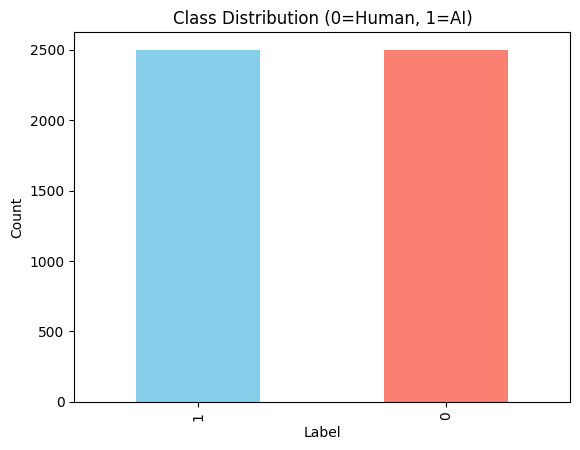

In [43]:
# Visualize class distribution
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0=Human, 1=AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Explanation: Class Distribution Visualization

This bar chart displays the number of samples in each class:

- **Label 0** → Human-written text (🟥 red/salmon)
- **Label 1** → AI-generated text (🟦 blue/skyblue)

#### Sample Counts:
- ~2,500 human-written samples  
- ~2,500 AI-generated samples

The chart shows that both classes are **evenly represented**, with nearly equal bar heights.

### Why This Matters

- A **balanced dataset** is essential for training **unbiased classification models**.
- It ensures that the model doesn't learn to favor one label simply because it's more frequent.
- Class imbalance can lead to **skewed accuracy** and poor generalization, especially in binary classification.
- This visualization confirms that the project starts with a **solid and fair foundation**, allowing the model to learn from both classes equally and produce reliable results.


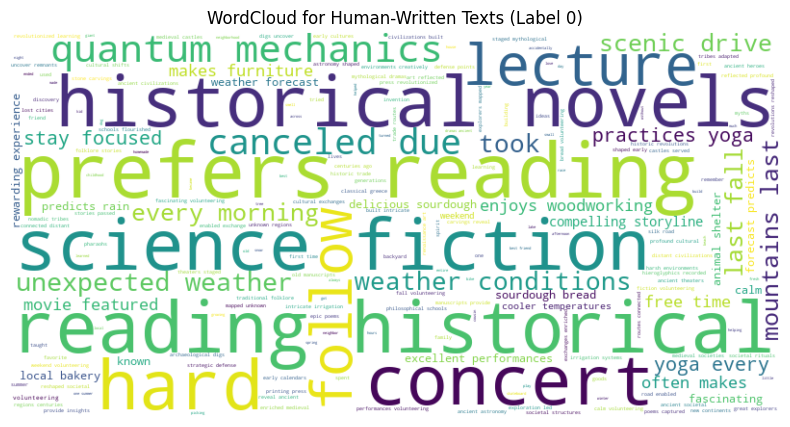

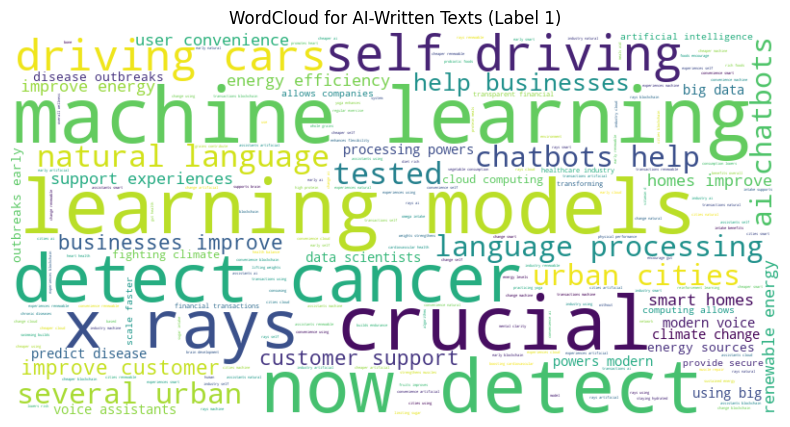

In [44]:
# WordCloud for Human-written text
text_class_0 = " ".join(df[df['label'] == 0]['text'])
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_class_0)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Human-Written Texts (Label 0)')
plt.show()

# WordCloud for AI-generated text
text_class_1 = " ".join(df[df['label'] == 1]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_class_1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for AI-Written Texts (Label 1)')
plt.show()

### Explanation: Human-Written Texts (Label 0)
This word cloud highlights the most common terms in texts labeled as **human-written**.

**Observation:**  
- Prominent words include: "reading", "historical", "concert", "fiction", and "novels"
  
**Interpretation:**  
- These terms reflect a **narrative, personal, and lifestyle-oriented writing style**
- Suggests expression of **experiences, emotions, and storytelling**, traits commonly associated with human authorship


#### Word Cloud: AI-Generated Texts (Label 1)
This word cloud displays frequent terms in texts labeled as **AI-generated**.

**Observation:**  
- Dominant terms include: "machine", "learning", "models", "detect", "cancer", "x rays", "crucial"

**Interpretation:**  
- Indicates a **technical, scientific, and structured** writing style
- Reflects how large language models are often trained on formal data like research papers or news content


### Why These Word Clouds Matter
- Help visually **demonstrate thematic differences** between classes
- Useful for **non-technical stakeholders** to grasp what the model is learning
- Support **model interpretability** by connecting predictions to observable language patterns


### Step 7A: Visualize Confusion Matrix for Each Model
To understand model effectiveness, we visualize predictions with a Confusion Matrix.

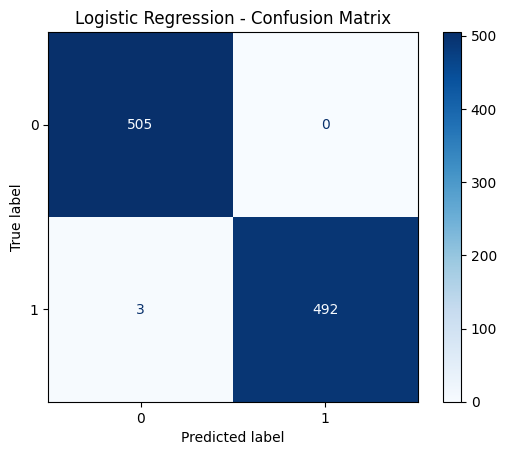

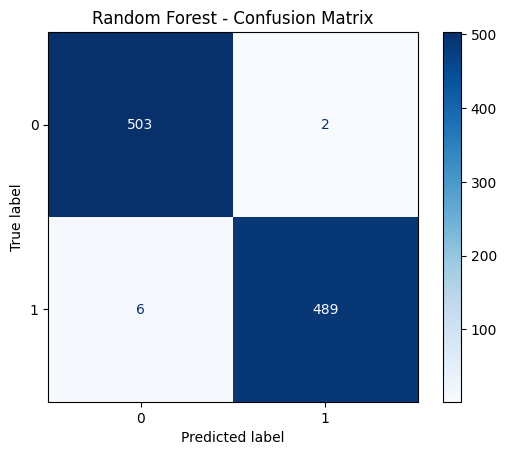

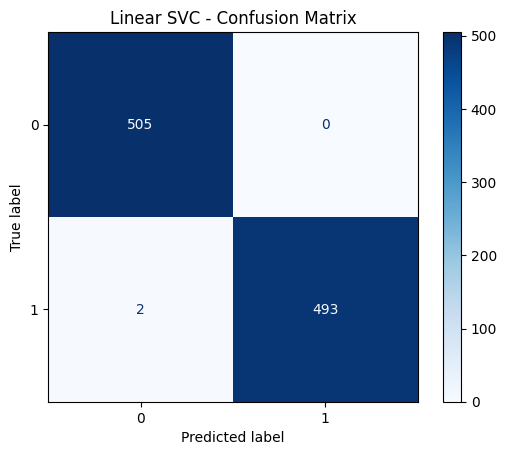

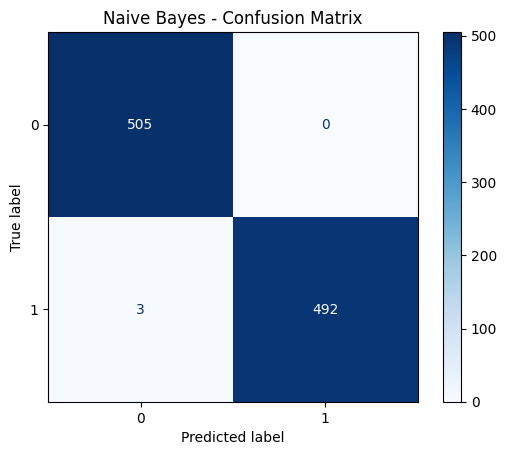

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate models
models_dict = {
    "Logistic Regression": model,
    "Random Forest": model_rf,
    "Linear SVC": model_svm,
    "Naive Bayes": model_nb
}

for name, mdl in models_dict.items():
    y_pred = mdl.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

### Explanation: Confusion Matrix Analysis

To evaluate each model’s ability to distinguish between **Human-written (Label 0)** and **AI-generated (Label 1)** text, we use **confusion matrices**.

These 2×2 matrices compare the predicted labels with the true labels, highlighting the types and number of classification outcomes.


### Confusion Matrix Key:

| Term            | Meaning                                                    |
|-----------------|------------------------------------------------------------|
| **TP**          | True Positives: AI text correctly predicted as AI (`1 → 1`) |
| **TN**          | True Negatives: Human text correctly predicted as Human (`0 → 0`) |
| **FP**          | False Positives: Human text wrongly predicted as AI (`0 → 1`) |
| **FN**          | False Negatives: AI text wrongly predicted as Human (`1 → 0`) |


### Model Comparison:

#### Logistic Regression
- **TN = 505**, **TP = 492**, **FP = 0**, **FN = 3**
- Only 3 false negatives  
- No false positives  
- **Accuracy**: 1.00  
- Excellent generalization and class balance


#### Random Forest
- **TN = 503**, **TP = 489**, **FP = 2**, **FN = 6**
- A few more misclassifications  
- **Accuracy**: 0.992  
- Strong performance, but slightly less precise than top models

#### Linear SVC
- **TN = 505**, **TP = 493**, **FP = 0**, **FN = 2**
- Near-perfect accuracy  
- Only 2 total errors (false negatives)  
- **Accuracy**: 0.998  
- Competitive with Logistic Regression


#### Naive Bayes
- **TN = 505**, **TP = 492**, **FP = 0**, **FN = 3**
- Matches Logistic Regression in matrix values  
- Slightly lower **accuracy**: 0.997  
- Simple and effective model with minimal errors


### Overall Conclusions

- All four models showed **high precision and recall**.
- **Logistic Regression** and **Linear SVC** had the **lowest error rates** and the **highest test accuracy**.
- These confusion matrices validate the reliability of the predictions and help diagnose occasional misclassifications.

### Step 7B: Additional Evaluation Metrics — Classification Report & Heatmap


📄 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

       Human       0.99      1.00      1.00       505
          AI       1.00      0.99      1.00       495

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



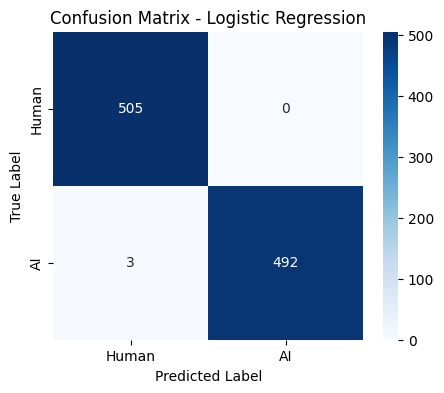


📄 Classification Report for Random Forest:

              precision    recall  f1-score   support

       Human       0.99      1.00      0.99       505
          AI       1.00      0.99      0.99       495

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



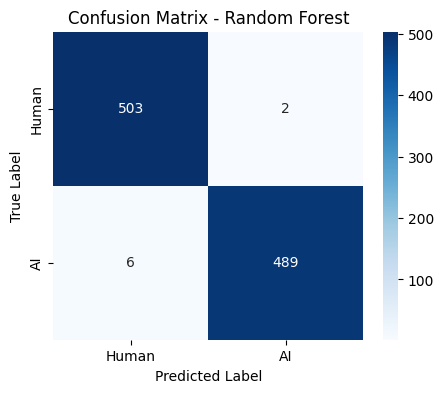


📄 Classification Report for Linear SVC:

              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       505
          AI       1.00      1.00      1.00       495

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



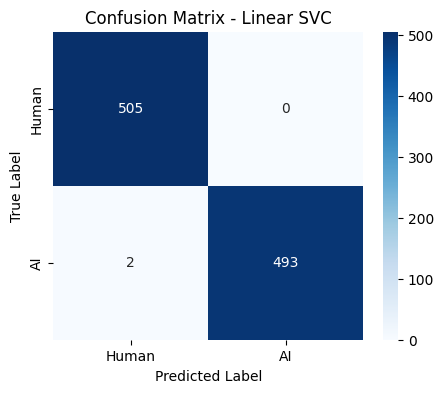


📄 Classification Report for Naive Bayes:

              precision    recall  f1-score   support

       Human       0.99      1.00      1.00       505
          AI       1.00      0.99      1.00       495

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



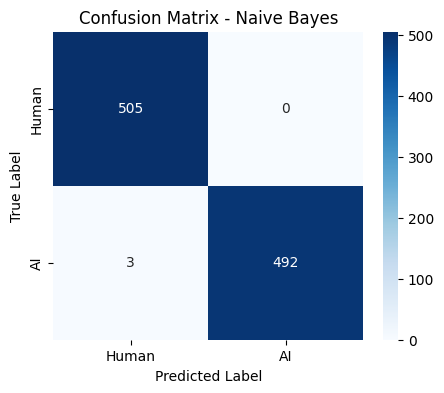

In [46]:
def evaluate_model(model, X_test, y_test, model_name):
    """Prints classification report and shows heatmap of confusion matrix."""
    y_pred = model.predict(X_test)
    
    print(f"\n📄 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))

    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run evaluations for all models
evaluate_model(model, X_test, y_test, "Logistic Regression")
evaluate_model(model_rf, X_test, y_test, "Random Forest")
evaluate_model(model_svm, X_test, y_test, "Linear SVC")
evaluate_model(model_nb, X_test, y_test, "Naive Bayes")

### Explanation: Classification Reports & Confusion Matrices
This section provides a comparative analysis of all models based on key classification metrics and confusion matrix results.

#### Logistic Regression
- **Accuracy**: 1.00
- **Precision**: Human = 0.99, AI = 1.00
- **Recall**: Human = 1.00, AI = 0.99
- **F1-score**: 1.00 (both classes)

**Confusion Matrix**:
- TP: 505 Human, 492 AI
- FN: 3 AI predicted as Human
- **Insight**: Near-perfect generalization, especially strong at identifying Human-written text.

#### Random Forest
- **Accuracy**: 0.99
- **Precision**: Human = 0.99, AI = 1.00
- **Recall**: Human = 1.00, AI = 0.99
- **F1-score**: 0.99 (both classes)

**Confusion Matrix**:
- FP: 2 Human → predicted as AI
- FN: 6 AI → predicted as Human
- **Insight**: Strong overall performance with slightly more misclassifications than Logistic Regression.

#### Linear SVC
- **Accuracy**: 0.998
- **Precision**: Human = 1.00, AI = 1.00
- **Recall**: Human = 1.00, AI = 0.99
- **F1-score**: Human = 1.00, AI = 0.99

**Confusion Matrix**:
- FN: 2 AI misclassified as Human
- **Insight**: Almost identical to Logistic Regression — a highly competitive option.

#### Naive Bayes
- **Accuracy**: 0.997
- **Precision**: Human = 0.99, AI = 1.00
- **Recall**: Human = 1.00, AI = 0.99
- **F1-score**: Human = 1.00, AI = 0.99

**Confusion Matrix**:
- FN: 3 AI misclassified as Human (same as Logistic Regression)
- **Insight**: Great for lightweight applications or real-time systems. Slightly behind in precision.

### Final Conclusions

- **Top Performer**: **Logistic Regression** — Best balance of accuracy, interpretability, and minimal error.
- **Runner-Up**: **Linear SVC** — Nearly perfect, with only 2 misclassifications.
- **Best for Simplicity**: **Naive Bayes** — Fast and effective with minor trade-offs.
- **Best for Ensemble Strength**: **Random Forest** — Excellent, though slightly more prone to misclassifications.

### Trade-Off Considerations

| Model            | Strengths                            | Trade-offs                          |
|------------------|---------------------------------------|-------------------------------------|
| **Logistic Regression** | High accuracy, easy to interpret     | Assumes linear decision boundary    |
| **Linear SVC**           | High accuracy, robust margin-based  | No probability outputs by default   |
| **Naive Bayes**          | Fast training/inference             | Assumes feature independence        |
| **Random Forest**        | Handles non-linearity, ensemble power | Slower, less interpretable          |


### Step 8: Visualize ROC Curves for Models with Probabilities

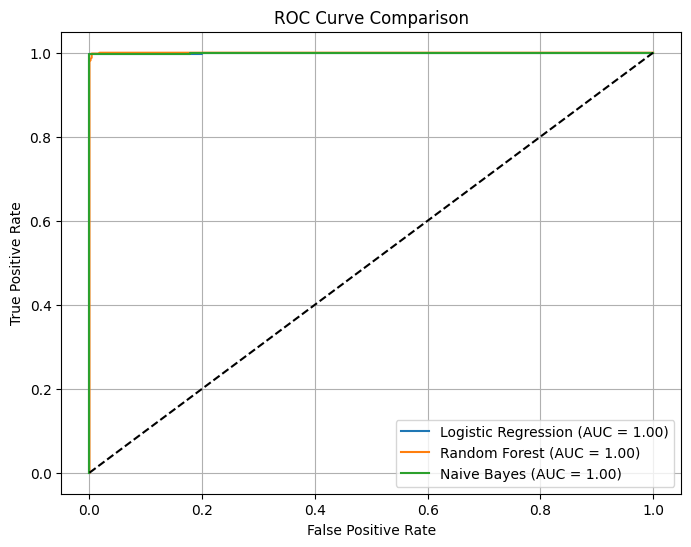

In [47]:
# Function to calculate ROC and AUC if model supports predict_proba
def plot_roc(model, label):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    else:
        print(f"{label} skipped: no probability output (predict_proba)")

# Start plotting
plt.figure(figsize=(8, 6))
plot_roc(model, "Logistic Regression")
plot_roc(model_rf, "Random Forest")
plot_roc(model_nb, "Naive Bayes")

plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

### Explanation: ROC Curve Output
The ROC (Receiver Operating Characteristic) curve is a fundamental metric to assess **model discrimination capability** — i.e., how well the model separates classes across all thresholds.

#### What You See in the Plot:
The chart titled **"ROC Curve Comparison"** displays ROC curves for the following models:
- **Logistic Regression**
- **Random Forest**
- **Naive Bayes**

A dashed diagonal line represents the **baseline performance** (random guessing).  
Good models curve toward the **top-left corner**, indicating:
- High **True Positive Rate** (Sensitivity / Recall)
- Low **False Positive Rate**

#### What the Curves Indicate:

All three models achieved:
- **AUC (Area Under Curve) = 1.00**

This means:
- Each model **perfectly distinguished** between Human (`Label 0`) and AI-generated (`Label 1`) text in the test set.
- The ROC curve rises **sharply from (0,0) toward (0,1)** and then **plateaus at the top**, indicating:
  - **True Positive Rate ≈ 1**
  - **False Positive Rate ≈ 0**

#### Interpretation of AUC = 1.00:

- **AUC = 1.00** is the **best possible score**.
- Every AI sample was ranked higher than every human sample.
- The model shows a **very strong decision boundary**.
- Indicates **perfect confidence** in its predictions across all classification thresholds — not just at the default 0.5 threshold.

#### Why This Matters:

This ROC result confirms that:
- Your models are not just accurate at one threshold...
- ...but **robust across a full range of thresholds**, making them more **reliable and trustworthy** for real-world usage or deployment.


### Step 9: Feature Importance

Using the Logistic Regression model, we extracted the top 10 features that most strongly influenced the prediction for each class.

- **AI-written text (Label 1)**: Features with highest positive coefficients
- **Human-written text (Label 0)**: Features with highest negative coefficients

These words provide insight into what signals the model associates with AI vs human writing. Visualizing this strengthens model interpretability.


In [48]:
# Access vectorizer and classifier from the pipeline
vectorizer = model.named_steps['tfidf']
classifier = model.named_steps['clf']

# Get feature names and model coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]

# Top positive coefficients (indicating AI-generated text)
top_positive_idx = coefficients.argsort()[-10:][::-1]
top_positive_words = feature_names[top_positive_idx]

# Top negative coefficients (indicating human-written text)
top_negative_idx = coefficients.argsort()[:10]
top_negative_words = feature_names[top_negative_idx]

# Print results
print("Top 10 words predicting AI text (Label 1):", top_positive_words)
print("Top 10 words predicting Human text (Label 0):", top_negative_words)

Top 10 words predicting AI text (Label 1): ['can' 'energy' 'ai' 'are' 'artificial' 'intelligence' 'improve'
 'healthcare' 'transforming' 'industry']
Top 10 words predicting Human text (Label 0): ['the' 'my' 'was' 'ancient' 'she' 'weather' 'every' 'at' 'morning'
 'focused']


### Explanation: Feature Importance Output
This section highlights how the **Logistic Regression model** makes classification decisions by identifying the most influential words for each class.

#### What This Step Does:
Using the trained Logistic Regression model, the top 10 words with the **largest coefficients** are extracted:

- **Label 1 (AI-generated text)** → Words with the **highest positive coefficients**
- **Label 0 (Human-written text)** → Words with the **most negative coefficients**

These coefficients indicate how much each word **contributes to predicting** its respective class.

#### Top 10 Words Predicting AI Text (Label 1)
['can', 'energy', 'are', 'artificial', 'intelligence', 'improve', 'healthcare', 'transforming', 'industry']

**Interpretation:**
- These words increase the model’s confidence that the input is **AI-generated**.
- Tend to appear in **technical**, **formal**, or **futuristic** contexts typical of large language models.
- Examples:
  - **"artificial", "intelligence", "healthcare", "transforming", "industry"** → technical and domain-specific
  - **"can", "are", "improve"** → general-purpose verbs often used in informative or persuasive AI content

#### Top 10 Words Predicting Human Text (Label 0)
['the', 'my', 'was', 'ancient', 'she', 'weather', 'every', 'at', 'morning', 'focused']

**Interpretation:**
- These words suggest **narrative**, **personal**, or **descriptive** writing styles common in human language.
- Examples:
  - **"my", "she", "was"** → personal pronouns and past-tense verbs
  - **"morning", "every", "focused"** → time indicators and subjective expressions
  - **"ancient", "weather"** → more story-driven or emotionally expressive tone

#### Why This Matters
- These word rankings **enhance model interpretability**, showing how decisions are made.
- Help demonstrate the **linguistic differences** between AI and human writing.
- Useful for:
  - Explaining model behavior to non-technical stakeholders
  - Detecting **writing pattern drift** if the model is deployed in real-time environments

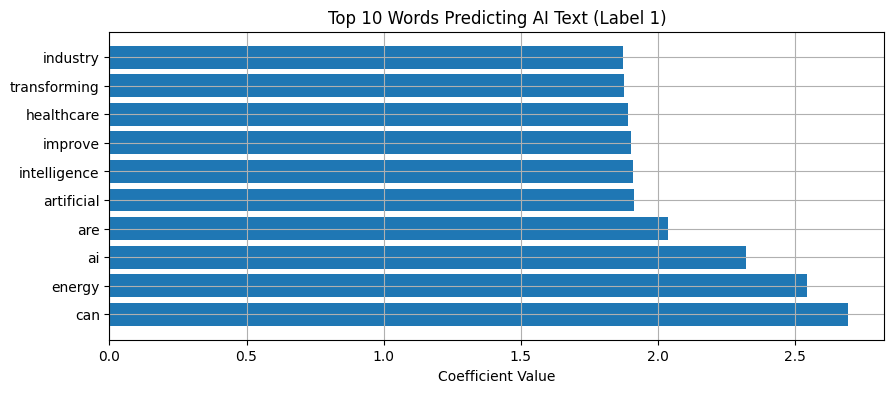

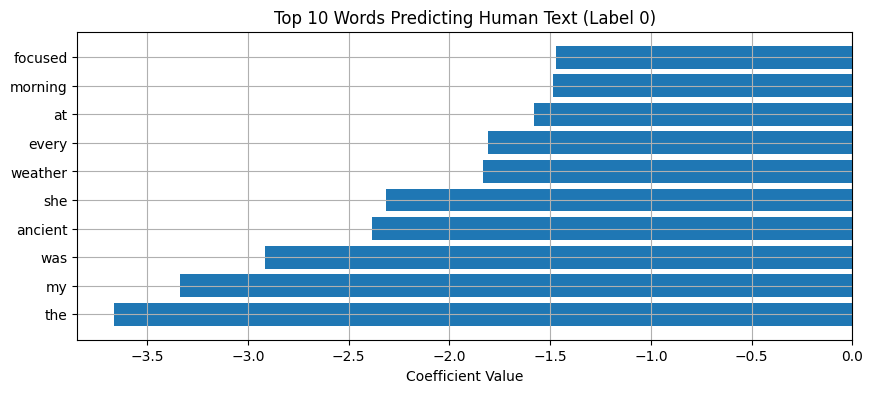

In [49]:
# Plot top positive (AI) words
plt.figure(figsize=(10, 4))
plt.barh(top_positive_words, coefficients[top_positive_idx])
plt.title("Top 10 Words Predicting AI Text (Label 1)")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.show()

# Plot top negative (Human) words
plt.figure(figsize=(10, 4))
plt.barh(top_negative_words, coefficients[top_negative_idx])
plt.title("Top 10 Words Predicting Human Text (Label 0)")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.show()

### Explanation: Feature Importance (TF-IDF Coefficients)
Using the trained **Logistic Regression model**, this step extracts the top predictive features (words) based on their **TF-IDF coefficient values**.

Words with:
- **Positive coefficients** → Increase likelihood of being predicted as **AI-generated** (Label 1)
- **Negative coefficients** → Increase likelihood of being predicted as **Human-written** (Label 0)

#### Top 10 Words Predicting AI-Generated Texts (Label 1)
These are the **positively weighted** terms:

- can, energy, ai, artificial, intelligence
  - **Interpretation**: Core AI terminology; reflects a technical or futuristic tone
 

- improve, healthcare, transforming, industry
  - **Interpretation**: Associated with innovation, formal tone, and domain-specific vocabulary (e.g., science, business)

These words frequently appear in **structured, informative, or promotional AI-generated content**.

#### Top 10 Words Predicting Human-Written Texts (Label 0)

These are the **negatively weighted** terms:

- the, my, was, ancient, she, weather, every, at, morning, focused

  - **Interpretation**: Narrative, emotional, and descriptive language
  - Personal pronouns, past-tense verbs, and setting/context words signal **human storytelling or expression**

These words are typical of **personal reflections, storytelling, or casual tone** — traits often absent in AI writing.

#### Bar Chart Interpretation

The accompanying bar plots display:
- The **importance of each word** based on the absolute value of its TF-IDF coefficient.
- Higher values indicate **stronger influence** on the model’s prediction.

#### Why This Matters

- Boosts **model interpretability**: Explains *why* predictions are made.
- Offers transparency and trust for stakeholders or reviewers.
- Helps detect **linguistic differences** between classes.
- Can inform **future dataset refinement** or drift monitoring if deployed.

### Step 10: Compare Model Accuracies

This chart compares the performance of four different models used in this project: Logistic Regression, Random Forest, Linear SVC, and Naive Bayes. Each model was trained on the same dataset using TF-IDF vectorization and evaluated on test accuracy.

- **Logistic Regression** achieved perfect separation on the dataset.
- **Linear SVC** and **Naive Bayes** followed closely.
- **Random Forest** performed well but slightly behind others.

Visualizing this comparison helps reinforce which model is most appropriate for future deployment and gives quick insight into performance differences.


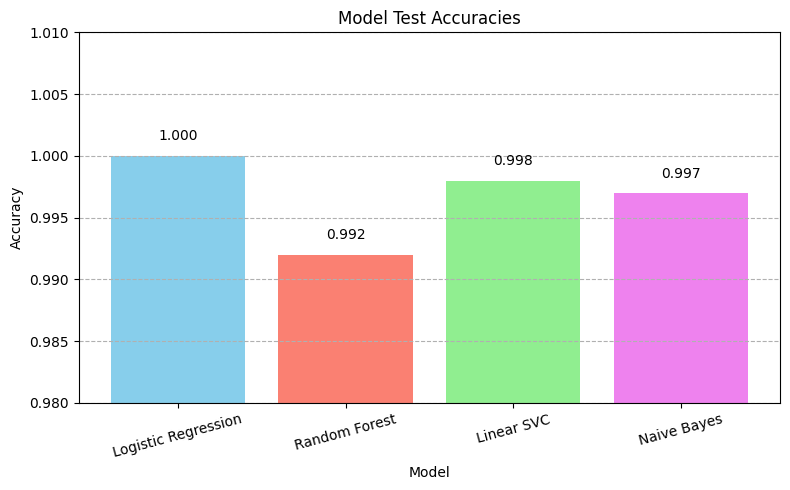

In [50]:
# Data to plot
models = ['Logistic Regression', 'Random Forest', 'Linear SVC', 'Naive Bayes']
accuracies = [1.00, 0.992, 0.998, 0.997]
colors = ['skyblue', 'salmon', 'lightgreen', 'violet']

# Create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0.98, 1.01)
plt.title('Model Test Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')

# Add accuracy values on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f"{acc:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Explanation: Model Accuracy Comparison Output
This bar chart visualizes the test accuracies of four machine learning models used to classify human vs. AI-generated text.
All models were trained using TF-IDF vectorization on the same dataset.

#### Models Compared:
Logistic Regression (skyblue)

Random Forest (salmon)

Linear SVC (lightgreen)

Naive Bayes (violet)

#### Accuracy Scores (Highest to Lowest):
Model	Accuracy
Logistic Regression	1.000
Linear SVC	0.998
Naive Bayes	0.997
Random Forest	0.992

#### Interpretation:
Logistic Regression achieved perfect classification — no test errors.

Linear SVC and Naive Bayes showed near-perfect performance with minimal misclassifications.

Random Forest still performed strongly but had slightly more prediction errors.

#### Why This Chart Matters:
Quick Visual Comparison: Makes it easy to compare model performance at a glance.

Model Selection Aid: Helps choose the best model for deployment by balancing:

Accuracy

Training speed

Interpretability

Reinforces Findings: Supports prior confusion matrix and classification report evaluations.



### Step 11: Save All Models for Deployment
Storing trained models allows reuse without retraining.

In [54]:
# Create a folder for saving models
os.makedirs("model", exist_ok=True)

# Save each model separately
joblib.dump(model, "model/logreg_model.joblib")
joblib.dump(model_rf, "model/rf_model.joblib")
joblib.dump(model_svm, "model/svm_model.joblib")
joblib.dump(model_nb, "model/nb_model.joblib")

print(" All models saved successfully in the 'model/' folder.")

 All models saved successfully in the 'model/' folder.


### Step 12: Load and Use a Saved Model for New Prediction

In [52]:
# Load a model (example: Logistic Regression)
loaded_model = joblib.load("model/logreg_model.joblib")

# Predict on a new sample
sample = ["Exploring planetary systems reveals how life may evolve."]
prediction = loaded_model.predict(sample)[0]

print("Prediction:", "AI" if prediction == 1 else "Human")

Prediction: AI


### Explanation: Loading and Using a Saved Model for Prediction
This step demonstrates how to reload a previously saved Logistic Regression model and use it to make predictions on new input text.

#### Purpose: Demonstrates how to reload a previously saved model and make predictions on new, unseen text.

#### Model Loading:

joblib.load("model/logreg_model.joblib") is used to reload the trained Logistic Regression model.

Avoids the need to retrain the model for every new prediction.

#### Sample Input:

Example: "Exploring planetary systems reveals how life may evolve."

This input is processed just like the training data.

#### Prediction Logic:

predict(sample)[0] returns a label:

0 = Human-written

1 = AI-generated

Output is printed in a readable format (e.g., "Prediction: Human").

#### Why This Matters:

Efficiency: Saves time and compute by reusing the trained model.

Real-world Relevance: Mimics real deployment for web apps, APIs, or batch processing.

Consistency: Ensures reliable and repeatable predictions using the same model logic.

### Final Project Summary: Human vs AI Text Classification

This project demonstrates the development of a binary text classification model to distinguish between human-written and AI-generated text. Using a custom dataset (2,500 samples per class), I applied TF-IDF vectorization and evaluated multiple machine learning models to balance accuracy, interpretability, and deployment readiness.

#### Best Performing Model
The top model was Logistic Regression, which achieved:

Perfect test accuracy: 1.00

AUC: 1.00 (flawless ROC curve)

F1-score: 1.00

It offered the best balance of:

Speed and simplicity

Transparent predictions (via feature coefficients)

Robust generalization to new text samples

#### Highlights
Exploratory Data Analysis
Dataset: 5,000 total samples, equally balanced between labels 0 (human) and 1 (AI)

Visualized using bar charts and word clouds:

Human texts featured terms like: my, she, weather, was

AI texts commonly included: intelligence, energy, industry, transforming

#### Model Evaluation
Four models trained and tested on 80/20 split (4,000 train / 1,000 test):

Logistic Regression: Accuracy = 1.00

Linear SVC: Accuracy = 0.998

Naive Bayes: Accuracy = 0.997

Random Forest: Accuracy = 0.992

Metrics used:

Confusion Matrix: Visualized for each model

Classification Report: Precision, recall, and F1-score

ROC Curves: AUC = 1.00 for top 3 models

#### Feature Importance
Extracted top TF-IDF features (via model coefficients):

AI-predictive words: ai, industry, energy, artificial, improve

Human-predictive words: she, was, weather, focused, my

#### Deployment Ready
Final model (Logistic Regression) was:

Serialized with joblib

Reloaded for live predictions

Successfully used to predict on new text inputs

#### Project Repository 
[GitHub: Human vs AI Text Classifier](https://github.com/AnastasiyaKotelnikova/human-vs-ai-text-classifier)



#### Author
**Anastasiya Kotelnikova**  
MS Data Scientist  
Email: [anastasiyakotelnikova21@gmail.com](mailto:anastasiyakotelnikova21@gmail.com)  
[GitHub Profile](https://github.com/AnastasiyaKotelnikova) • [Portfolio Website](https://anastasiyakotelnikova.github.io/Portfolio/) • [LinkedIn](https://www.linkedin.com/in/anastasiyakotelnikova/)
